## Example Situation

* early phase-II for new anti-cancer drug
* endpoint: 6 months RECIST objective response rate
* no usable data on response rate from phase I
* historical response rate of $\rho_0=0.1$
* minimum clinically interesting improvement of $\delta=0.1$
* expert opinion: true response rate of new compound between $0.05$ and $0.4$
* $\alpha=0.05$, $1-\beta=0.8$
* fit Beta distribution such that prior probability of both $\rho<0.05$ and $\rho>0.4$ is 5%

In [1]:
rho0  = 0.1
delta = 0.1
alpha = 0.05
beta  = 0.2

0.2

### Define prior PDF

In [13]:
import Distributions # load required packages

f(p) = Distributions.pdf(Distributions.Beta(2.45, 10.0), p)

f (generic function with 1 method)

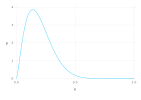

In [25]:
using Gadfly

plot(x = 0:.01:1, y = f.(0:.01:1), Geom.line)

### Derive prior conditional on $\rho \geq \rho_0 + \delta$

In [15]:
using Roots, QuadGK

# partition function
z = quadgk(f, rho0 + delta, 1.0)[1]

# PDF
fc(p) = p >= rho0 + delta ? f(p) / z : 0.0

# CDF
Fc(p) = quadgk(fc, rho0 + delta, p)[1]

# Quantile
Qc(p) = find_zero(x -> Fc(x) - p, (0, 1))

Qc (generic function with 1 method)

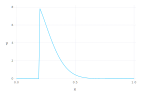

In [26]:
plot(x = 0:.01:1, y = fc.(0:.01:1), Geom.line)

### Define $\eta$ and compute $1 - \eta$ quantile for power constraint 

In [16]:
eta = .66

rho1 = Qc(1 - eta)

0.24863335682398205

## Optimize!

In [19]:
using BinaryTwoStageDesigns # package available at https://github.com/kkmann/BinaryTwoStageDesigns
using Gurobi

# provide suitable boundaries for the search space
ss     = SampleSpace(
  15:25, # n1 range
  75     # maximal overall sample size
)

# define solver, note Gurobi requires commercial software but is much faster
# alternative is e.g. Cbc solver in julia package Cbc.jl
solver = GurobiSolver()

# provide the remaining parameters
params = MBESS2(
  ss,   # sample space 
  .1,   # rho0
  rho1, # rho1 (for power constraint)
  f,    # prior pdf function
  alpha = .05, 
  beta = .2, 
  MONOTONECONDITIONALPOWER = false
)

MBESS2

In [20]:
nicedesign = optimaldesign(15, params, solver)

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Optimize a model with 402 rows, 75168 columns and 2602209 nonzeros
Variable types: 0 continuous, 75168 integer (75168 binary)
Coefficient statistics:
  Matrix range     [1e-13, 2e+02]
  Objective range  [6e-05, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-02, 2e+02]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 119 rows and 61874 columns
Presolve time: 4.30s
Presolved: 283 rows, 13294 columns, 440856 nonzeros
Variable types: 0 continuous, 13294 integer (13294 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.020000e+01   0.000000e+00      6s
      72    2.7003970e+01   0.000000e+00   0.000000e+00      6s

Root relaxation: objective 2.700397e+01, 72 iterations, 0.04 seconds

    Nodes    |    Current Node    |     Objective Bounds      |    

Design

Quite a lot of output, let's shut the solver up and optimize over the entire range!

In [21]:
solver = GurobiSolver(OutputFlag = 0)
nicedesign, res = optimaldesign(params, solver, EARLYTERMINATION = true)


optimizing design for parameters ''
considering 11 stage-one sample sizes between 15 and 25 using Gurobi.GurobiSolver as solver
    time    n1   % done   sol. time [s]   cum. time [min]       score        best   % diff to best
00:35:49    15      9.1              13               0.2   +2.74e+01   +2.74e+01              0.0
00:36:02    16     18.2              14               0.5   +2.73e+01   +2.73e+01              0.0
00:36:16    17     27.3              16               0.7   +2.74e+01   +2.73e+01              0.4
00:36:32    18     36.4              16               1.0   +2.72e+01   +2.72e+01              0.0
00:36:47    19     45.5              20               1.3   +2.72e+01   +2.72e+01              0.0
00:37:07    20     54.5              26               1.7   +2.75e+01   +2.72e+01              1.1
00:37:33    21     63.6              23               2.1   +2.77e+01   +2.72e+01              2.1
00:37:56    22     72.7              19               2.4   +2.81e+01   +2.72e+

(, Dict{String,Any}(Pair{String,Any}("scores", [27.4033, 27.3001, 27.4112, 27.1904, 27.1929, 27.4846, 27.7494, 28.1208, 28.1087, 28.4454, 28.9014]),Pair{String,Any}("n1", [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]),Pair{String,Any}("designs", BinaryTwoStageDesigns.Design[, , , , , , , , , , ])))

DesignDesignDesignDesignDesignDesignDesignDesignDesignDesignDesign

In [24]:
using DataFrames

DataFrame(nicedesign)

,x1,n,c
1,0,18,Inf
2,1,18,Inf
3,2,18,Inf
4,3,48,8.0
5,4,52,9.0
6,5,18,-Inf
7,6,18,-Inf
8,7,18,-Inf
9,8,18,-Inf
10,9,18,-Inf


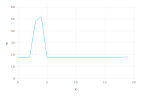

In [28]:
plot(x = DataFrame(nicedesign)[:x1], y = DataFrame(nicedesign)[:n], Geom.line)

## Inference

In [29]:
est = OCEstimator(nicedesign, solver)

OCEstimator

In [33]:
estimate(est, 3, 10)

0.2717293946947193

In [34]:
pvalue(est, 3, 10, .1)

0.02829257147570655

In [35]:
ci = ECPInterval(est, confidence = .9)

limits(ci, 3, 10)

2-element Array{Float64,1}:
 0.117
 0.372